# Project - Topics in Big Data Analytics

## Sentiment analysis on Twitter data

In [133]:
# Load libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
import tensorflow_text as text
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from transformers import TFAutoModel, AutoTokenizer
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mowni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
# Import dataset
df = pd.read_csv("twitter_data.csv", encoding = 'latin', header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [135]:
#Prepare data by removing unnecessary columns
df = df[[0, 5]]
df.columns = ['sentiments', 'tweet']  #labels for columns
df = df.replace([4], [1])  #replacing sentiment 4 with 1
df = df[['sentiments', 'tweet']].dropna()     #drop where NaNs present

In [136]:
df.head()

,sentiments,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [137]:
# Analysing the data

df.shape

(1600000, 2)

In [138]:
df.groupby('sentiments').describe()

tweet                                        
             count  unique                        top freq
sentiments                                                
0           800000  790185  isPlayer Has Died! Sorry   210
1           800000  793506              good morning   118

In [139]:
# # The dataset is very large, so I take .02%, Stratified sampling to balance
sampleDf = df.groupby('sentiments', group_keys=False).apply(lambda x: x.sample(frac=0.01))
ps = PorterStemmer()

In [140]:
sampleDf.shape

(16000, 2)

In [141]:
sampleDf.groupby('sentiments').describe()

tweet                                                            \
           count unique                                                top   
sentiments                                                                   
0           8000   7990                          isPlayer Has Died! Sorry    
1           8000   7995  Watching Kobe Doin' Work inside my bed  http:/...   

                 
           freq  
sentiments       
0             4  
1             2

# Text Preprocessing

In [142]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)              # remove all letters and numbers after @ sign, in sentence (text)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)    # remove urls, http and https, many times as need it
    tweet = re.sub(r"[^A-za-z.!?']", ' ', tweet)              # remove chars that are not AZ,az, !?'
    tweet = re.sub(r'[.,"\'-?:!;]', ' ', tweet)
    tweet = re.sub(r" +", ' ', tweet)                         # replace white spaces (at least two or more) to one white space
    return tweet

In [143]:
sampleDf['tweet'] = sampleDf.tweet.apply(clean_tweet)

C:\Users\mowni\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [144]:
X_train, X_test, y_train, y_test = train_test_split(sampleDf['tweet'], sampleDf['sentiments'], test_size=0.30, stratify=sampleDf['sentiments'])

In [145]:
y_train.value_counts()

1    5600
0    5600
Name: sentiments, dtype: int64

In [146]:
y_test.value_counts()

0    2400
1    2400
Name: sentiments, dtype: int64

# Embedding layer using tensor flow BERT model

In [147]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [148]:
# Bert layers
tweet_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  #Input layer
preprocessed_tweet = bert_preprocess(tweet_input)  #Keras layer
outputs = bert_encoder(preprocessed_tweet)    #Keras layer 1
# Neural network layers
layer1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) #Dropout layer
layer2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1)  #Output layer

# Use inputs and outputs to construct a final model
bert_model = tf.keras.Model(inputs=[tweet_input], outputs = [layer2])
# model = tf.keras.models.load_model('path/to/location')
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [149]:
bert_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                     metrics=['accuracy'])

In [150]:
bert_model.fit(X_train, y_train, epochs=3)

Epoch 1/3
350/350 [==============================] - 2421s 7s/step - loss: 0.6776 - accuracy: 0.5713
Epoch 2/3
350/350 [==============================] - 2360s 7s/step - loss: 0.6330 - accuracy: 0.6457
Epoch 3/3
350/350 [==============================] - 2318s 7s/step - loss: 0.6069 - accuracy: 0.6776


In [151]:
bert_model.evaluate(X_test, y_test)

150/150 [==============================] - 1016s 7s/step - loss: 0.6023 - accuracy: 0.6660


[0.6022523641586304, 0.6660416722297668]

In [152]:
y_pred = bert_model.predict(X_test)

150/150 [==============================] - 999s 7s/step


In [159]:
y_pred = np.where(y_pred[:,0]>0.5, 1, 0)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

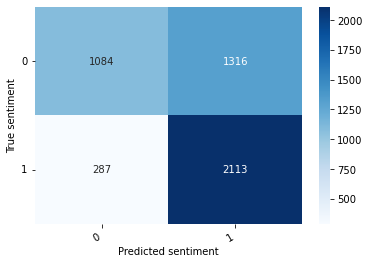

In [154]:
cm = confusion_matrix(y_test, y_pred )
class_names = ['negative', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment');

In [156]:
accuracy_score(y_test, y_pred)

0.6660416666666666

In [168]:
metric_names = ['precision','recall','f1-score','support']
metric_values = precision_recall_fscore_support(y_test, y_pred)
for i in range(0, len(metric_values)):
    # print('{0}: {1}'.format(metric_names[i], metric_values[i]))
    print('{0}: {1}'.format(metric_names[i], metric_values[i][1]))

precision: 0.6162146398366871
recall: 0.8804166666666666
f1-score: 0.7249957110996741
support: 2400


In [158]:
print(f'auc_score_bert: {roc_auc_score(y_test, bert_model.predict(X_test))}')

150/150 [==============================] - 1006s 7s/step
auc_score_bert: 0.7756272569444446


# Sentiment analysis using Random forest classifier

In [17]:
# Data pre-professing in text
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer # reference; https://www.nltk.org/_modules/nltk/stem/wordnet.html
# nltk.download('wordnet')

stop_words = stopwords.words('english')
print(f'The number of stopword: {len(stop_words)}')
punctuations = string.punctuation
print(f'The number of punctuations: {len(punctuations)}')
lemma = WordNetLemmatizer()

def clean_text_list(text_list):
    # step1. lower  
    lower =  [x.lower() for x in text_list]   # Ref: https://stackoverflow.com/questions/1801668/convert-a-python-list-with-strings-all-to-lowercase-or-uppercase
    
    # step2. split  
    split =  [x.split() for x in lower]  
 
    # step3. remove stopwords
    no_stopword = [[i for i in doc if i not in stop_words] for doc in split]

    # step4. remove punctuations
    no_punctuations = [[i for i in doc if i not in punctuations] for doc in no_stopword] 
    
    # step5. remove numbers, but not words that contain numbers.
    no_number = [[token for token in doc if not token.isnumeric()] for doc in no_punctuations]
    
    # step6. remove single charater
    no_single_chararter = [[token for token in doc if len(token) > 1] for doc in no_number]

    # step7. Lemmatizer
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in no_single_chararter]
    return docs

The number of stopword: 179
The number of punctuations: 32


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mowni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mowni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
tweet_train = X_train.tolist()
tweet_test = X_test.tolist()

In [ ]:
# tweet_total = tweet_train+tweet_test

In [52]:
tweet_train_docs = clean_text_list(tweet_train)
tweet_test_docs = clean_text_list(tweet_test)
# print(tweet_docs[0])


In [67]:
tweet_train_docs[0]

['watching', 'snl', 'sibling', 'like', 'good', 'old', 'day']

In [59]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
tweet_train_list =[]
for i in range(len(tweet_train_docs)):
  docs_detokenized = TreebankWordDetokenizer().detokenize(tweet_train_docs[i])
  tweet_train_list.append(docs_detokenized )
    
tweet_test_list =[]
for i in range(len(tweet_test_docs)):
  docs_detokenized = TreebankWordDetokenizer().detokenize(tweet_test_docs[i])
  tweet_test_list.append(docs_detokenized )

In [61]:
print(len(tweet_train_list))
print(len(tweet_test_list))

11200
4800


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [ ]:
## implement BAG OF WORDS
countvector=CountVectorizer(ngram_range=(2,2))
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [ ]:
countvector.fit(tweet_train_list)
train_dataset=countvector.transform(tweet_train_list)
test_dataset=countvector.transform(tweet_test_list)
transformer.fit(train_dataset)
x_train_rf = transformer.transform(train_dataset)
x_test_rf = transformer.transform(test_dataset)

In [ ]:
print(x_train_rf.shape)
print(x_test_rf.shape)

(11200, 56146)
(4800, 56146)


In [84]:
# implement RandomForest Classifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(x_train_rf,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [86]:
y_pred_rf = randomclassifier.predict(x_test_rf)

In [87]:
y_pred_rf

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

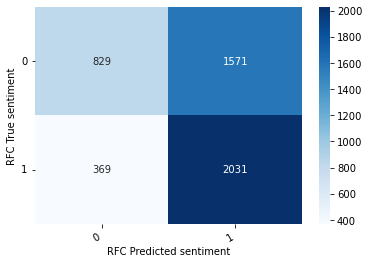

In [93]:
cm = confusion_matrix(y_test, y_pred_rf )
class_names = ['negative', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('RFC True sentiment')
plt.xlabel('RFC Predicted sentiment');

In [95]:
accuracy_score(y_test, y_pred_rf)

0.5958333333333333

In [169]:
metric_names = ['precision','recall','fscore','support']
metric_values = precision_recall_fscore_support(y_test, y_pred_rf)
for i in range(0, len(metric_values)):
    print('{0}: {1}'.format(metric_names[i], metric_values[i][1]))

precision: 0.5058300943920044
recall: 0.7591666666666667
fscore: 0.6071309563478839
support: 2400


In [120]:
randomclassifier.classes_

array([0, 1], dtype=int64)

In [132]:
roc_auc_score(y_test, randomclassifier.predict_proba(x_test_rf)[:,1])

0.5147393229166668